In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import time
import cv2
from cv2 import VideoCapture
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from moviepy.editor import VideoFileClip, concatenate_videoclips


C:\ProgramData\Miniconda2\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load Images - Block 2


car_images =  glob.glob('./vehicles/vehicles/KITTI_extracted/*.png')
time_series = glob.glob('./vehicles/vehicles/Time_Series/*.png')
time_series = time_series + glob.glob('./vehicles/vehicles/GTI_Far/*.png')
time_series = time_series + glob.glob('./vehicles/vehicles/GTI_Left/*.png')
time_series = time_series + glob.glob('./vehicles/vehicles/GTI_MiddleClose/*.png')
time_series = time_series + glob.glob('./vehicles/vehicles/GTI_Right/*.png')

non_car_images = glob.glob('./non-vehicles/non-vehicles/GTI/*.png')
non_car_images = non_car_images + glob.glob('./non-vehicles/non-vehicles/Extras/*.png')

print(len(car_images))
print(len(non_car_images))
print(len(time_series))

5966
8968
2826


In [3]:
#Feature Extraction Functions - Block 3

def convert_color(image, cspace='RGB'):
    if cspace == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if cspace == 'YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    if cspace == 'LUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    if cspace == 'HLS':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if cspace == 'YUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    if cspace == 'RGB':
        rgb_scale = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
        return cv2.cvtColor(rgb_scale, cv2.COLOR_BGR2RGB)

def get_hog_features(image, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    if vis == True:
        features, hog_image = hog(image, orientations=orient, 
                                  pixels_per_cell = (pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt = False,
                                  visualise = vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(image, orientations=orient,
                       pixels_per_cell = (pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt = False,
                       visualise = vis, feature_vector=feature_vec)
        return features
    
def bin_spatial(image, size=(32,32)):
    c1 = cv2.resize(image[:,:,0], size).ravel()
    c2 = cv2.resize(image[:,:,1], size).ravel()
    c3 = cv2.resize(image[:,:,2], size).ravel()
    return np.hstack((c1, c2, c3))

def color_hist(image, nbins=32, bins_range=(0,256)):
    c1_hist = np.histogram(image[:,:,0], bins=nbins)
    c2_hist = np.histogram(image[:,:,1], bins=nbins)
    c3_hist = np.histogram(image[:,:,2], bins=nbins)
    hist_features = np.concatenate((c1_hist[0], c2_hist[0], c3_hist[0]))
    return hist_features

def extract_features(images, cspace='RGB', spatial_size = (32,32),
                     hist_bins = 32, hist_range = (0,256),
                     orient = 9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    features = []
    for file in images:
        image = mpimg.imread(file)
        feature_image = convert_color(image, cspace)
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features) 
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    return features
    

In [26]:
 # Extract Features - Block 4
    
cspace = 'YCrCb'
spatial_size = (32,32) 
hist_bins = 32
hist_range = (0,256)
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

car_features = extract_features(car_images, cspace=cspace, 
                                spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel
                               )

non_car_features = extract_features(non_car_images, cspace=cspace, 
                                spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel
                               )


time_series_features = extract_features(time_series, cspace=cspace, 
                                spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel
                               )

In [27]:
# Scale our data - Blokc 5
X = np.vstack((car_features, non_car_features)).astype(np.float64)
X_time_series = np.vstack((time_series_features)).astype(np.float64)
Xscale = np.vstack((car_features, non_car_features, time_series_features)).astype(np.float64)

X_scaler = StandardScaler().fit(Xscale)
scaled_X = X_scaler.transform(X)
scaled_time_series = X_scaler.transform(X_time_series)



In [28]:
# Train Test Split our Data - 6
rand_state = np.random.randint(0,100)    
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = .25, random_state = rand_state)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

X_train = np.vstack((X_train, scaled_time_series))
y_train = np.hstack((y_train, np.ones(len(scaled_time_series))))

print(' - ')
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))


11200
11200
3734
3734
 - 
14026
14026
3734
3734


In [29]:
# Fit our Data - Block 7

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t3=time.time()
print(round(t3-t2), 'Seconds to test SVC...')


13 Seconds to train SVC...
Test Accuracy of SVC =  0.9938
0 Seconds to test SVC...


In [30]:
# Test to ensure feature exctraction is working - Block 8

print(X_train[0][0])

single_features = extract_features([car_images[0]], cspace=cspace, 
                                spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel
                               )

stacked_image = np.vstack((single_features)).astype(np.float64)

print(stacked_image)

scaled_image = X_scaler.transform(stacked_image)
print([scaled_image])

-0.726634325056
[[ 0.14764707  0.13553727  0.11670785 ...,  0.005556    0.00362257
   0.00093419]]
[array([[-0.88395013, -0.94458115, -1.03853363, ..., -0.86120178,
        -0.91832455, -0.87035287]])]


In [31]:
# Box Finding Functions - Block 9

ystart = 400
ystop = 656
scale = 1.5

def find_cars(image, cspace, ystart, ystop, 
              scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):

    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    #image = image.astype(np.float32) # Scaling with /255 for now, still discerning affects
   
    img_tosearch = image[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace=cspace)
    
    if scale!=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    #nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Extract our hog features once
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    
    
    # Move a Sliding Window across our image
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # grab our hog feautres for each channel in our window.
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            # Match our cell to search to our window size
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Grab the rest of our features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale and Predict
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            # Add boxes to list
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = (xbox_left, ytop_draw + ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)
                cv2.rectangle(draw_image,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw + win_draw + ystart), (0,0,255),6)
                box_list.append(box)
                
    return draw_image, box_list           

(720, 1280, 3)


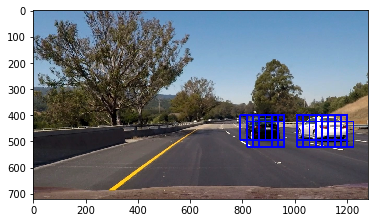

In [32]:
# Test our pipeline = Block 10

test_img = mpimg.imread('./test_images/test6.jpg')
image = np.copy(test_img)

print(test_img.shape)
out_img, box_list = find_cars(test_img, cspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()   

In [33]:
# Define our Heat functions - Block 11

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] +=3
    heatmap[heatmap >= 0] -=2
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <=threshold] = 0
    return heatmap

def draw_labeled_boxes(image, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
    return image

In [34]:
# Define a vehicle class for tracking heat across multiple images - Block 12

heat_threshold = 1

class vehicle_tracker():
    def __init__(self):
        self.heatmap = None
        self.heat = None
        self.heat_threshold = heat_threshold
        self.labels = None
        self.last_boxes = None
        self.current_boxes = None
    def heater(self, image, box_list):
        self.heat = add_heat(self.heat, box_list)
        self.heat = apply_threshold(self.heat, self.heat_threshold)
        self.heat = np.clip(self.heat, -12, 10)
        self.heatmap = self.heat
        self.labels = label(self.heatmap)
        draw_image = draw_labeled_boxes(np.copy(image), self.labels)
        cv2.imshow('heat', self.heatmap)
        #if cv2.waitKey(1) & 0xFF == ord('q'):
        return draw_image
        

    

In [35]:
# Define our Pipeline

def vehicle_pipeline(frame):
    image = np.copy(frame)
    out_image, box_list = find_cars(image, cspace, ystart, ystop, 
                                    scale, svc, X_scaler, orient, 
                                    pix_per_cell, cell_per_block, 
                                    spatial_size, hist_bins)
    draw_image = vehicles.heater(image, box_list)
    
    return draw_image, out_image

In [36]:
# Run our Pipline

zero_image = mpimg.imread('./test_images/test6.jpg')
vehicles = vehicle_tracker()
vehicles.heat = np.zeros_like(zero_image[:,:,0].astype(np.float))

# Read in our first frame
ret = True
cap = cv2.VideoCapture('project_video.mp4')
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Set video writing parameters
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
vid_name = './out_video/project_video_out' + str(cspace) + '000plus_minus.avi'
out = cv2.VideoWriter(vid_name, fourcc, 24.0, size, isColor=True)

# Run for length of video
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        frame, out_image = vehicle_pipeline(frame)
        
        f2 = frame.copy()
        f2 = cv2.cvtColor(f2, cv2.COLOR_RGB2BGR)
        out.write(f2)
        
        cv2.imshow('frame', out_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

        
# Release our videos and such
out.release()
cap.release()
cv2.destroyAllWindows()
print('Video Processed')



Video Processed


./vehicles/vehicles/KITTI_extracted\1.png


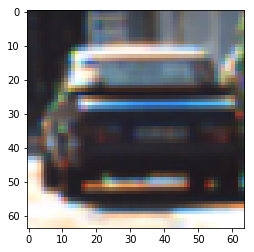

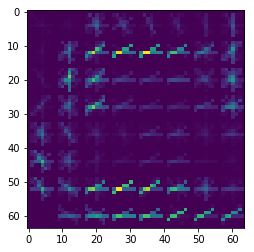

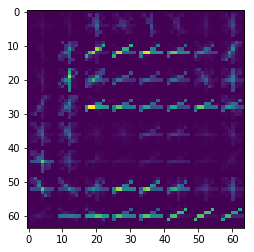

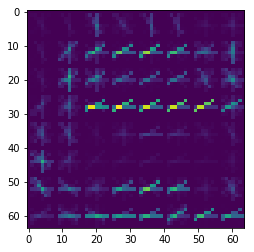

In [37]:



# End of program Image Generation

print(car_images[0])

image = mpimg.imread(car_images[0])
new_list = [car_images[0]]
new_list.append(car_images[1])

plt.imshow(image)
plt.show()

imooge = extract_features([car_images[0]])

features, hog_image1 = get_hog_features(image[:,:,0], orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       vis=True, feature_vec=True)
plt.imshow(hog_image1)
plt.show()

features, hog_image2 = get_hog_features(image[:,:,1], orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       vis=True, feature_vec=True)
plt.imshow(hog_image2)
plt.show()

features, hog_image3 = get_hog_features(image[:,:,2], orient=orient, 
                                       pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       vis=True, feature_vec=True)
plt.imshow(hog_image3)
plt.show()

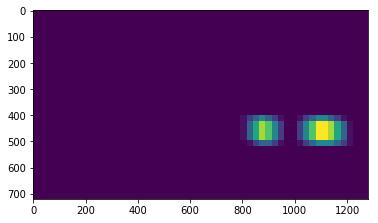

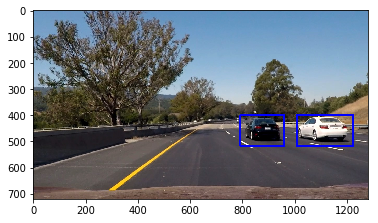

In [38]:
heat_image = mpimg.imread('./test_images/test6.jpg')
heat = np.zeros_like(heat_image[:,:,0].astype(np.float))
heat = add_heat(heat, box_list)
heat = apply_threshold(heat,0)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_boxes(np.copy(heat_image), labels)

plt.imshow(heatmap)
plt.show()
plt.imshow(draw_img)
plt.show()